Results for Emilia Clarke


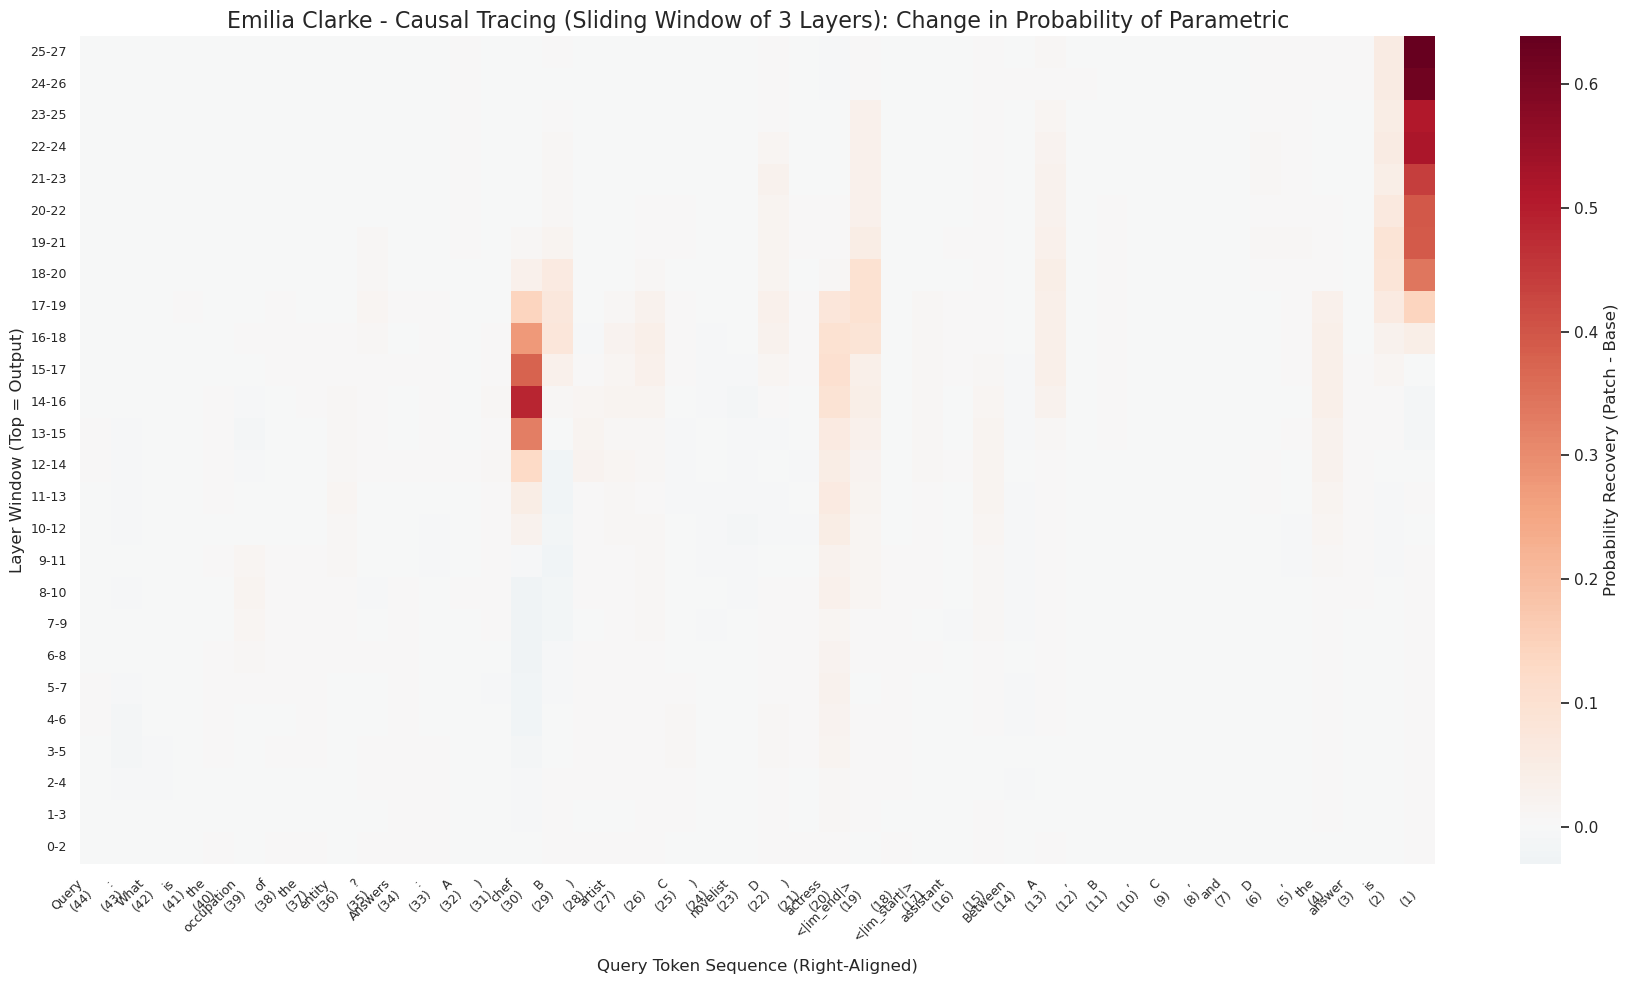

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


csv_path = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Patching_Query_SlidingWindow_Prob.csv"
df = pd.read_csv(csv_path)
df = df[df['Error_type'] == 'Career_error']

#QUERY LENGTH 47
# QUERY_LENGTH = 49
# new_query_mask = (df['ID'] != df['ID'].shift()) | (df['Token_Pos_From_End'] < df['Token_Pos_From_End'].shift())
# df['Query_Session'] = new_query_mask.cumsum()

# session_maxes = df.groupby('Query_Session')['Token_Pos_From_End'].transform('max')

# df_47 = df[session_maxes == QUERY_LENGTH].copy()

# df = df_47.drop(columns=['Query_Session'])
# curr_ent = f"Query length {QUERY_LENGTH}"
##############


#ONLY LOOK AT ONE ENTITY
curr_ent = df['Entity'].unique()[39] #8-Tom Holland and 4 Mark Zuckerberg are very interesting #15 - Benedict Cumberbatch
#curr_ent = 'Benedict Cumberbatch'
print(f"Results for {curr_ent}")
df = df[df['Entity'] == curr_ent]
##############

#### PLOT ALL FOR THE LAST PART ############
#curr_ent = "All"
#df = df[df['Token_Pos_From_End'] <= 20]
####

first_id = df['ID'].unique()[0]
example_df = df[df['ID'] == first_id].sort_values("Token_Pos_From_End", ascending=False)
token_map_df = example_df.drop_duplicates(subset=['Token_Pos_From_End'])
pos_to_token = dict(zip(token_map_df['Token_Pos_From_End'], token_map_df['Token']))

heatmap_data = df.groupby(['Window_Start', 'Token_Pos_From_End'])['Recovery'].mean().reset_index()

pivot_table = heatmap_data.pivot(index='Window_Start', columns='Token_Pos_From_End', values='Recovery')


cols_sorted = sorted(pivot_table.columns, reverse=True)
pivot_table = pivot_table[cols_sorted]

pivot_table = pivot_table.sort_index(ascending=False)
x_labels = [f"{str(pos_to_token.get(col, '?')).strip()}\n({col})" for col in cols_sorted]
window_size = df['Window_Size'].iloc[0]
y_labels = [f"{int(i)}-{int(i+window_size-1)}" for i in pivot_table.index]


plt.figure(figsize=(18, 10))
sns.set_theme(style="white")

ax = sns.heatmap(
    pivot_table, 
    cmap="RdBu_r", 
    center=0,
    annot=False, 
    xticklabels=x_labels, 
    yticklabels=y_labels,
    cbar_kws={'label': 'Probability Recovery (Patch - Base)'}
)

plt.title(f"{curr_ent} - Causal Tracing (Sliding Window of {window_size} Layers): Change in Probability of Parametric", fontsize=16)
plt.xlabel("Query Token Sequence (Right-Aligned)", fontsize=12)
plt.ylabel("Layer Window (Top = Output)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

In [2]:

csv_path = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Patching_Query_SlidingWindow_Prob.csv"
df = pd.read_csv(csv_path)
df = df[df['Token_Pos_From_End'] != 1]
# 1) Find max Recovery per Entity
max_recovery = df.groupby('Entity')['Recovery'].max().reset_index()

# 2) Keep only rows achieving the max Recovery
df_max = df.merge(
    max_recovery,
    on='Entity',
    suffixes=('', '_max')
)
df_max = df_max[df_max['Recovery'] == df_max['Recovery_max']]

# 3) Count (Window_Start, Window_End) frequencies per Entity
counts = (
    df_max
    .groupby(['Entity', 'Window_Start', 'Window_End'])
    .size()
    .reset_index(name='count')
)

# 4) Take the most common window per Entity
result = (
    counts
    .sort_values(['Entity', 'count'], ascending=[True, False])
    .groupby('Entity')
    .head(1)
    .reset_index(drop=True)
)

result['Window_Start'].value_counts()


Window_Start
15    24
14    21
16     5
18     2
12     2
Name: count, dtype: int64

In [3]:
df[df['Token_Pos_From_End'] <= 20]

,ID,Entity,Error_type,Token,Token_Pos_From_End,Window_Start,Window_End,Window_Size,Base_Prob,Patched_Prob,Recovery
26,1,Taylor Swift,location_error,is,2,0,3,3,0.4021,0.403320,0.001221
27,1,Taylor Swift,location_error,is,2,1,4,3,0.4021,0.402100,0.000000
28,1,Taylor Swift,location_error,is,2,2,5,3,0.4021,0.402344,0.000244
29,1,Taylor Swift,location_error,is,2,3,6,3,0.4021,0.406250,0.004150
30,1,Taylor Swift,location_error,is,2,4,7,3,0.4021,0.403564,0.001465
...,...,...,...,...,...,...,...,...,...,...,...
103007,148,Chadwick Boseman,Career_error,ista,20,21,24,3,0.0672,0.067261,0.000061
103008,148,Chadwick Boseman,Career_error,ista,20,22,25,3,0.0672,0.067200,0.000000
103009,148,Chadwick Boseman,Career_error,ista,20,23,26,3,0.0672,0.067200,0.000000
103010,148,Chadwick Boseman,Career_error,ista,20,24,27,3,0.0672,0.066284,-0.000916


In [4]:
#Most common Query lengths
csv_path = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Patching_Query_SlidingWindow_Prob.csv"
df = pd.read_csv(csv_path)
df = df[df['Error_type'] == 'Career_error']

new_query_mask = (df['ID'] != df['ID'].shift()) | (df['Token_Pos_From_End'] < df['Token_Pos_From_End'].shift())
df['Query_Session'] = new_query_mask.cumsum()

# 2. Identify which Sessions have a max length of 47
# transform('max') spreads the maximum value to every row in that session
session_maxes = df.groupby('Query_Session')['Token_Pos_From_End'].transform('max')

# 3. Filter the dataframe
df_47 = df[session_maxes == 47].copy()

# Optional: Clean up by dropping the helper column
df_47 = df_47.drop(columns=['Query_Session'])
df_47['Entity'].unique()

df['Session_Max'] = df.groupby('Query_Session')['Token_Pos_From_End'].transform('max')

entity_counts_by_max = (
    df.groupby('Session_Max')['Entity']
      .nunique()
      .sort_index()
)

entity_counts_by_max


Session_Max
43    4
44    4
45    4
46    3
47    4
49    6
50    3
51    1
52    5
53    3
54    1
56    2
59    1
61    1
72    1
75    1
76    1
77    1
85    1
Name: Entity, dtype: int64

In [5]:
session_maxes

1170      52
1171      52
1172      52
1173      52
1174      52
          ..
103657    45
103658    45
103659    45
103660    45
103661    45
Name: Token_Pos_From_End, Length: 87022, dtype: int64

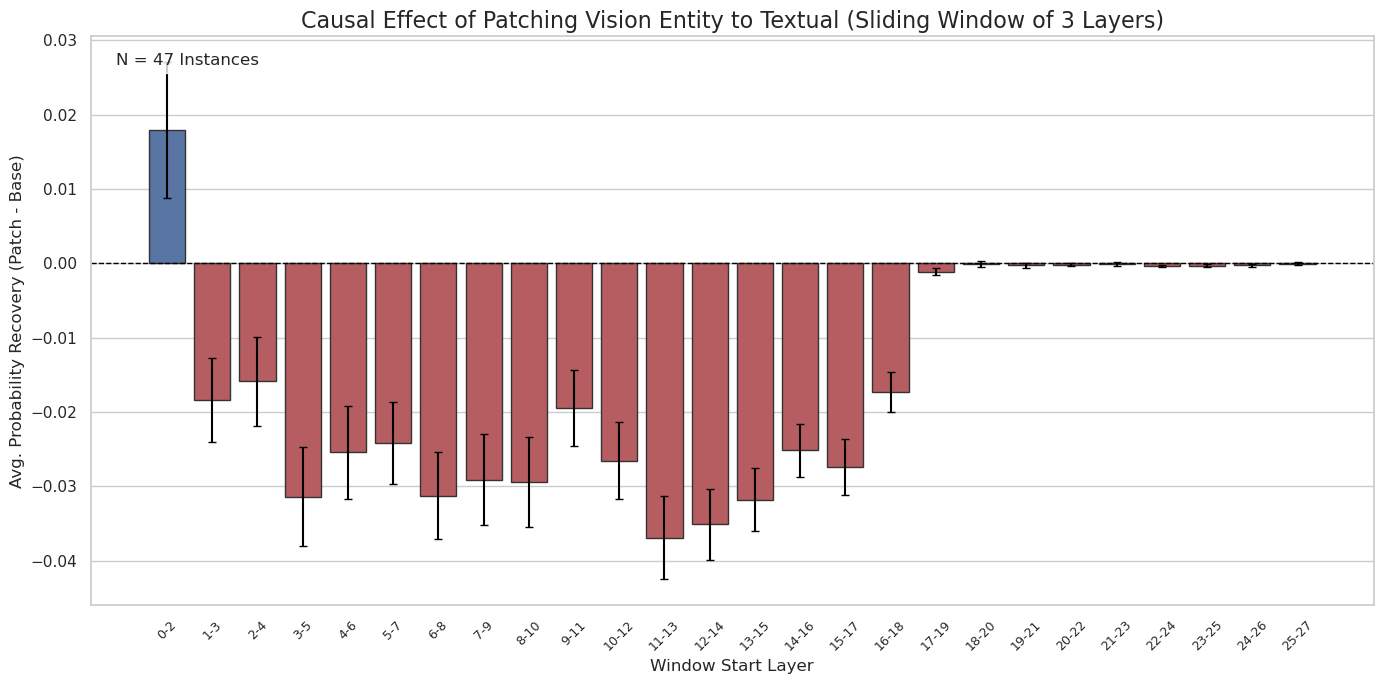

Top Performing Window: Layers 0-2
Max Average Recovery: 0.0180


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Load Data
# (Ensure this points to your NEW file with the sliding window results)
csv_path = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Patching_LastEntityToken_Corrected.csv"
df = pd.read_csv(csv_path)
df = df[df['Category'] == 'Career_error']

# 2. Aggregation
# Group by 'Window_Start' instead of 'Layer'
# This aggregates the effect for the window starting at X (e.g., Layers 10-14)
window_stats = df.groupby('Window_Start')['Recovery'].agg(['mean', 'sem']).reset_index()

# 3. Plotting
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")

# Define colors (Blue = Helped, Red = Hurt)
colors = ['#4c72b0' if x >= 0 else '#c44e52' for x in window_stats['mean']]

# A. Create Bar Plot
plot = sns.barplot(
    data=window_stats,
    x='Window_Start',
    y='mean',
    hue='Window_Start',
    palette=colors,
    legend=False,
    edgecolor=".2"
)

# B. Add Error Bars
plt.errorbar(
    x=window_stats.index, # Use index positions (0, 1, 2...) for correct alignment
    y=window_stats['mean'], 
    yerr=window_stats['sem'], 
    fmt='none', 
    c='black', 
    capsize=3, 
    elinewidth=1.5
)

# 4. Styling & Labels
window_size = df['Window_Size'].iloc[0] if 'Window_Size' in df.columns else "N"

plt.title(f"Causal Effect of Patching Vision Entity to Textual (Sliding Window of {window_size} Layers)", fontsize=16)
plt.ylabel("Avg. Probability Recovery (Patch - Base)", fontsize=12)
plt.xlabel("Window Start Layer", fontsize=12)

# Make X-Axis labels readable (e.g., "0-4", "1-5")
labels = [f"{int(i)}-{int(i+window_size-1)}" for i in window_stats['Window_Start']]
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, fontsize=9)

# Add zero line
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# Annotations
n_instances = df['ID'].nunique()
plt.text(0.02, 0.95, 
         f"N = {n_instances} Instances", 
         transform=plt.gca().transAxes, 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# 5. Interpretation Helper
best_window = window_stats.loc[window_stats['mean'].idxmax()]
start_l = int(best_window['Window_Start'])
end_l = start_l + int(window_size) - 1
print(f"Top Performing Window: Layers {start_l}-{end_l}")
print(f"Max Average Recovery: {best_window['mean']:.4f}")

In [7]:
csv_path = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Patching_LastEntityToken_Corrected.csv"
df = pd.read_csv(csv_path)
df

,ID,Instance,Category,Patched_Token_Str,Window_Start,Window_End,Window_Size,Base_Prob,Patched_Prob,Recovery
0,1,Taylor Swift,location_error,Swift,0,3,3,0.4021,0.415527,0.013428
1,1,Taylor Swift,location_error,Swift,1,4,3,0.4021,0.418213,0.016113
2,1,Taylor Swift,location_error,Swift,2,5,3,0.4021,0.416748,0.014648
3,1,Taylor Swift,location_error,Swift,3,6,3,0.4021,0.373047,-0.029053
4,1,Taylor Swift,location_error,Swift,4,7,3,0.4021,0.376709,-0.025391
...,...,...,...,...,...,...,...,...,...,...
2049,148,Chadwick Boseman,Career_error,man,21,24,3,0.0672,0.066284,-0.000916
2050,148,Chadwick Boseman,Career_error,man,22,25,3,0.0672,0.066284,-0.000916
2051,148,Chadwick Boseman,Career_error,man,23,26,3,0.0672,0.067200,0.000000
2052,148,Chadwick Boseman,Career_error,man,24,27,3,0.0672,0.066284,-0.000916


Loading data...
Saving plot to /users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Cosine_Similarity_Plot.png...
Done.


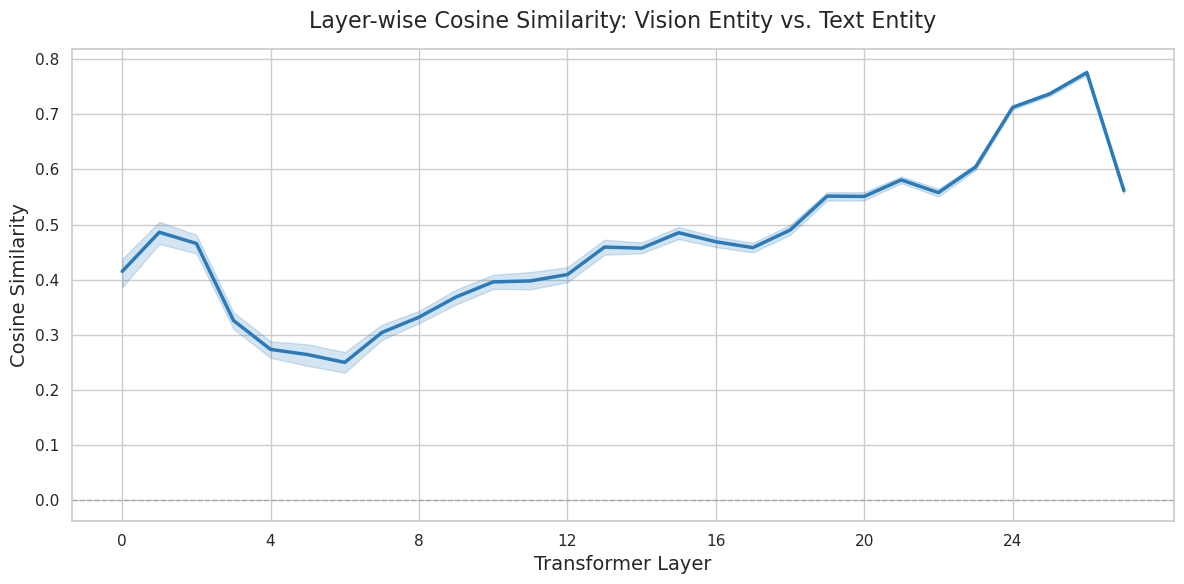

In [8]:
# Similarity between vision and text entity

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- CONFIG ---
INPUT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Cosine_Similarity.csv"
OUTPUT_PLOT = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Cosine_Similarity_Plot.png"

def plot_layerwise_similarity(csv_path, save_path):
    if not os.path.exists(csv_path):
        print(f"Error: File not found at {csv_path}")
        return

    print("Loading data...")
    df = pd.read_csv(csv_path)

    # Setup Plot Style
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # --- MAIN PLOT ---
    # sns.lineplot automatically calculates the mean and 95% confidence interval
    sns.lineplot(
        data=df,
        x="Layer",
        y="Cosine_Similarity",
        linewidth=2.5,
        color="#2b7bba"  # Nice professional blue
    )

    # --- FORMATTING ---
    plt.title("Layer-wise Cosine Similarity: Vision Entity vs. Text Entity", fontsize=16, pad=15)
    plt.xlabel("Transformer Layer", fontsize=14)
    plt.ylabel("Cosine Similarity", fontsize=14)
    
    # Set X-axis ticks to be integers (every 5 layers usually looks clean)
    max_layer = df["Layer"].max()
    plt.xticks(range(0, max_layer + 1, 4))
    
    # Optional: specific y-limits if you want to fix the scale (e.g., 0 to 1)
    # plt.ylim(0, 1.0) 

    # Add a horizontal reference line at 0 (orthogonality) if relevant
    plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    plt.tight_layout()
    
    print(f"Saving plot to {save_path}...")
    plt.savefig(save_path, dpi=300)
    print("Done.")

if __name__ == "__main__":
    plot_layerwise_similarity(INPUT_CSV, OUTPUT_PLOT)

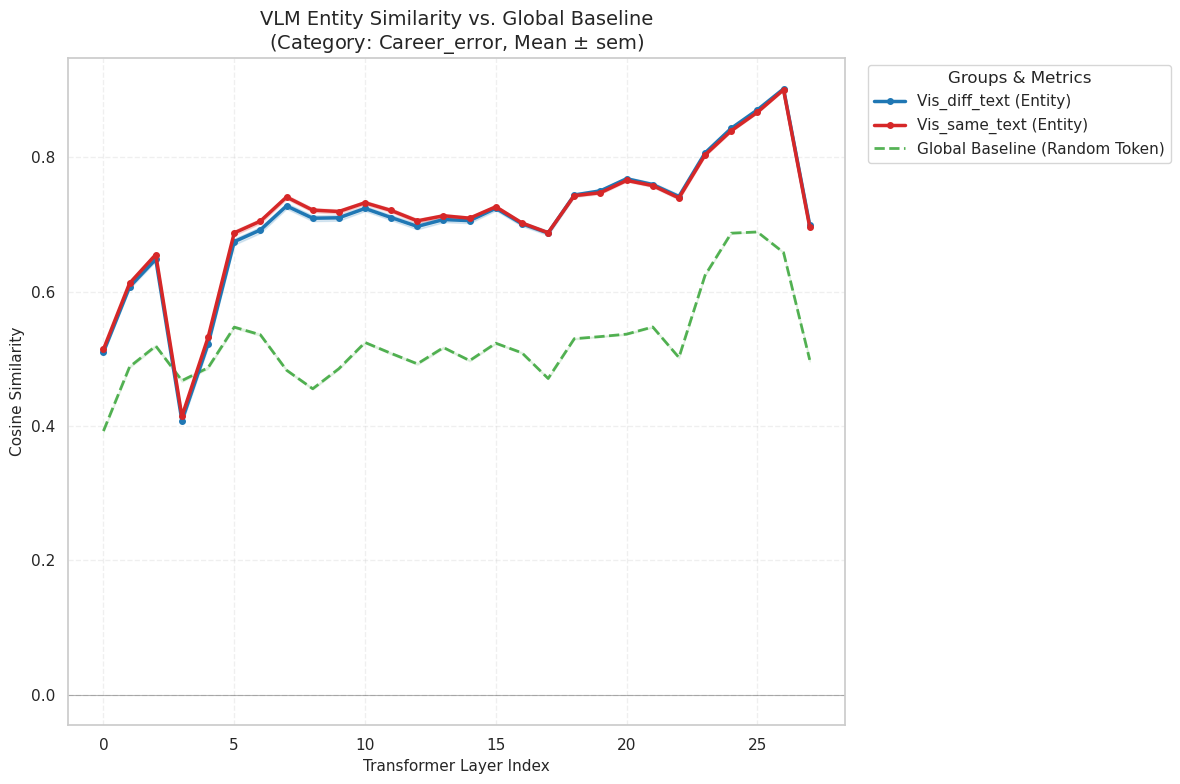

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
import os

# --- 1. SETUP & LOADING ---
FILE_PATH = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Cosine_Similarity_Grouped.csv"
df = pd.read_csv(FILE_PATH)

# 2. Filter for the specific category
df = df[df['Category'] == 'Career_error']

# --- 3. CALCULATE STATS ---
# Experimental Groups stats
df_stats = df.groupby(['Group', 'Layer']).agg({
    'Cosine_Similarity': ['mean', 'sem']
}).reset_index()

df_stats.columns = ['Group', 'Layer', 'Cosine_mean', 'Cosine_sem']

# SINGLE GLOBAL BASELINE stats (combining all rows regardless of Group)
global_baseline = df.groupby('Layer')['Baseline_Similarity'].agg(['mean', 'sem']).reset_index()

# --- 4. SETUP MAPPING AND STYLING ---
group_map = {
    'VisCorrect_TextWrong': 'Vis_same_text',
    'Others': 'Vis_diff_text'
}
colors = {
    'VisCorrect_TextWrong': '#d62728' , # Blue
    'Others': '#1f77b4'                # Red
}

# --- 5. PLOTTING ---
plt.figure(figsize=(12, 8))

# 5a. Plot the Experimental Groups (Blue and Red)
for group in df_stats['Group'].unique():
    subset = df_stats[df_stats['Group'] == group].sort_values('Layer')
    label = group_map.get(group, group)
    color = colors.get(group, 'gray')
    
    plt.plot(subset['Layer'], subset['Cosine_mean'], 
             label=f"{label} (Entity)", color=color, marker='o', markersize=4, 
             linewidth=2.5, zorder=3)
    
    plt.fill_between(
        subset['Layer'], 
        subset['Cosine_mean'] - subset['Cosine_sem'], 
        subset['Cosine_mean'] + subset['Cosine_sem'], 
        color=color, alpha=0.15, zorder=2
    )

# 5b. Plot the Consolidated Baseline (Green)
plt.plot(global_baseline['Layer'], global_baseline['mean'], 
         label="Global Baseline (Random Token)", color='#2ca02c', # Forest Green
         linestyle='--', linewidth=2, alpha=0.8, zorder=1)

plt.fill_between(
    global_baseline['Layer'], 
    global_baseline['mean'] - global_baseline['sem'], 
    global_baseline['mean'] + global_baseline['sem'], 
    color='#2ca02c', alpha=0.1, zorder=0
)

# --- 6. FORMATTING ---
plt.title("VLM Entity Similarity vs. Global Baseline\n(Category: Career_error, Mean $\pm$ sem)", fontsize=14)
plt.xlabel("Transformer Layer Index", fontsize=11)
plt.ylabel("Cosine Similarity", fontsize=11)

plt.axhline(0, color='black', linewidth=0.8, alpha=0.3)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title="Groups & Metrics", loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

In [10]:
df

,ID,Instance,Category,Group,Layer,Cosine_Similarity,Baseline_Similarity,Baseline_word
112,1,Taylor Swift,Career_error,Others,0,0.502167,0.391305,is
113,1,Taylor Swift,Career_error,Others,1,0.606466,0.492812,is
114,1,Taylor Swift,Career_error,Others,2,0.652212,0.518119,is
115,1,Taylor Swift,Career_error,Others,3,0.401732,0.465510,is
116,1,Taylor Swift,Career_error,Others,4,0.516414,0.482293,is
...,...,...,...,...,...,...,...,...
10747,149,Lupita Nyong'o,Career_error,Others,23,0.816114,0.626952,is
10748,149,Lupita Nyong'o,Career_error,Others,24,0.847627,0.687038,is
10749,149,Lupita Nyong'o,Career_error,Others,25,0.872955,0.688123,is
10750,149,Lupita Nyong'o,Career_error,Others,26,0.904317,0.658995,is


In [11]:
df

,ID,Instance,Category,Group,Layer,Cosine_Similarity,Baseline_Similarity,Baseline_word
112,1,Taylor Swift,Career_error,Others,0,0.502167,0.391305,is
113,1,Taylor Swift,Career_error,Others,1,0.606466,0.492812,is
114,1,Taylor Swift,Career_error,Others,2,0.652212,0.518119,is
115,1,Taylor Swift,Career_error,Others,3,0.401732,0.465510,is
116,1,Taylor Swift,Career_error,Others,4,0.516414,0.482293,is
...,...,...,...,...,...,...,...,...
10747,149,Lupita Nyong'o,Career_error,Others,23,0.816114,0.626952,is
10748,149,Lupita Nyong'o,Career_error,Others,24,0.847627,0.687038,is
10749,149,Lupita Nyong'o,Career_error,Others,25,0.872955,0.688123,is
10750,149,Lupita Nyong'o,Career_error,Others,26,0.904317,0.658995,is


In [12]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Last_tok_LogitLens_Grouped.csv")
df = df[df['Category'] == "Career_error"]
df

,ID,Entity,Category,Group,Layer,P_Parametric,P_Context,P_Diff
112,1,Taylor Swift,Career_error,Others,0,1.788139e-07,1.192093e-07,5.960464e-08
113,1,Taylor Swift,Career_error,Others,1,4.172325e-07,1.192093e-07,2.980232e-07
114,1,Taylor Swift,Career_error,Others,2,4.172325e-07,1.788139e-07,2.384186e-07
115,1,Taylor Swift,Career_error,Others,3,4.768372e-07,2.384186e-07,2.384186e-07
116,1,Taylor Swift,Career_error,Others,4,3.576279e-07,7.152557e-07,-3.576279e-07
...,...,...,...,...,...,...,...,...
10747,149,Lupita Nyong'o,Career_error,Others,23,1.788139e-07,7.748604e-07,-5.960464e-07
10748,149,Lupita Nyong'o,Career_error,Others,24,1.192093e-07,4.768372e-07,-3.576279e-07
10749,149,Lupita Nyong'o,Career_error,Others,25,0.000000e+00,2.980232e-07,-2.980232e-07
10750,149,Lupita Nyong'o,Career_error,Others,26,0.000000e+00,5.960464e-08,-5.960464e-08


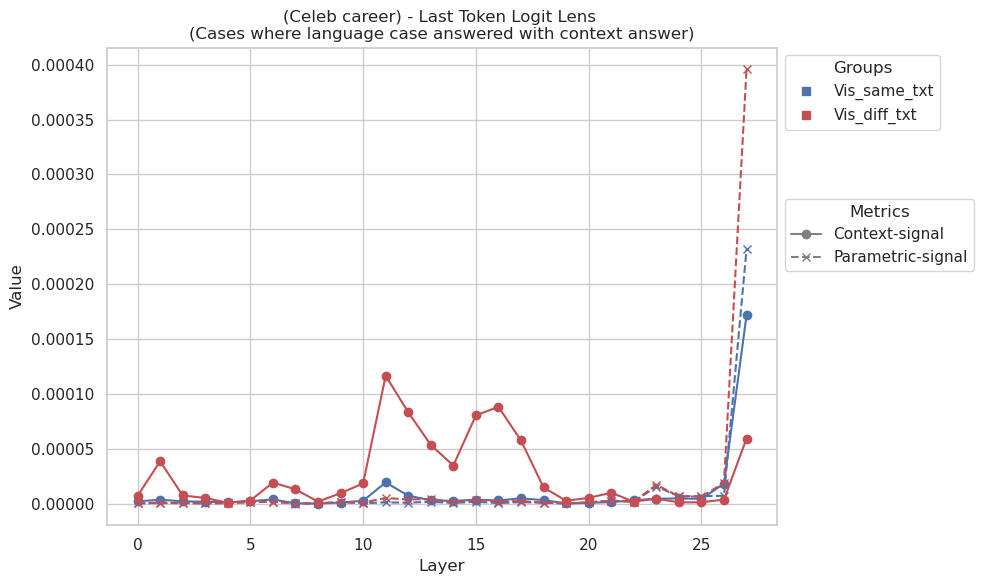

In [13]:
import matplotlib.lines as mlines
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Last_tok_LogitLens_Grouped.csv")
df = df[df['Category'] == "Career_error"]
df_avg = df.groupby(['Group', 'Layer'])[['P_Context', 'P_Parametric']].mean().reset_index()

group_map = {
    'VisCorrect_TextWrong': 'Vis_diff_txt',
    'Others': 'Vis_same_txt'
}

metric_map = {
    'P_Context': 'Context-signal',
    'P_Parametric': 'Parametric-signal'
}

plt.figure(figsize=(10, 6))
groups = df_avg['Group'].unique()

colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
# Plotting loop
for i, group in enumerate(groups):
    subset = df_avg[df_avg['Group'] == group].sort_values('Layer')
    color = colors[i % len(colors)]
    clean_group = group_map.get(group, group)
    
    plt.plot(subset['Layer'], subset['P_Context'], color=color, linestyle='-', marker='o')
    plt.plot(subset['Layer'], subset['P_Parametric'], color=color, linestyle='--', marker='x')

# --- 2. Create Custom Legend Handles ---

# Section 1: Groups (Colors)
# We create a list of colored lines to represent the groups
group_handles = [mlines.Line2D([], [], color=colors[i], marker='s', linestyle='None', 
                                label=group_map.get(g, g)) 
                 for i, g in enumerate(groups)]

# Section 2: Metrics (Styles)
# We create black lines with the specific styles to represent the metrics
metric_handles = [
    mlines.Line2D([], [], color='gray', linestyle='-', marker='o', label=metric_map['P_Context']),
    mlines.Line2D([], [], color='gray', linestyle='--', marker='x', label=metric_map['P_Parametric'])
]

# --- 3. Add both legends to the plot ---

# Add the first legend (Groups)
first_legend = plt.legend(handles=group_handles, title="Groups", loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().add_artist(first_legend) # This is the "trick" to keep the first legend from being deleted

# Add the second legend (Metrics/Styles)
plt.legend(handles=metric_handles, title="Metrics", loc='upper left', bbox_to_anchor=(1, 0.7))

plt.title("(Celeb career) - Last Token Logit Lens \n(Cases where language case answered with context answer)")
plt.xlabel('Layer')
plt.ylabel('Value')
plt.tight_layout()
plt.show()


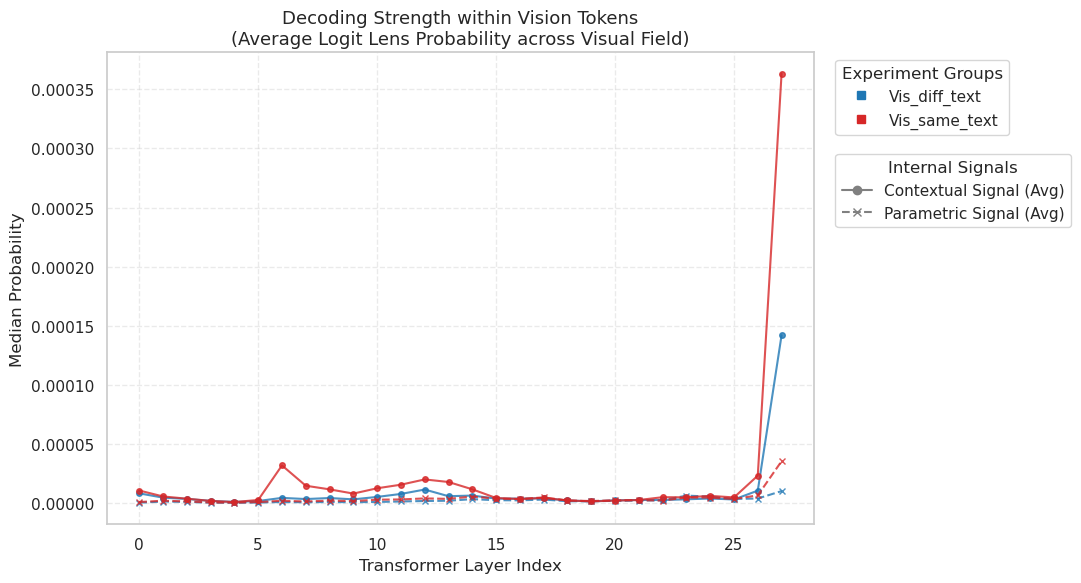

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# 1. Load and Prepare Data
OUT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Logit_Lens_Grouped.csv"
df = pd.read_csv(OUT_CSV)
df = df[df['Category'] == "Career_error"]
# Group by Layer and Group, calculating median probability
df_avg = df.groupby(['Group', 'Layer'])[['Avg_Vision_P_Context', 'Avg_Vision_P_Parametric']].mean().reset_index()

group_map = {
    'VisCorrect_TextWrong': 'Vis_same_text',
    'Others': 'Vis_diff_text'
}

metric_map = {
    'Avg_Vision_P_Context': 'Contextual Signal (Avg)',
    'Avg_Vision_P_Parametric': 'Parametric Signal (Avg)'
}

# 2. Plotting
plt.figure(figsize=(11, 6))
groups = df_avg['Group'].unique()
colors = ['#1f77b4', '#d62728'] # Using distinct blue and red for clarity

for i, group in enumerate(groups):
    subset = df_avg[df_avg['Group'] == group].sort_values('Layer')
    color = colors[i % len(colors)]
    
    # Plot Contextual probability (Solid line)
    plt.plot(subset['Layer'], subset['Avg_Vision_P_Context'], 
             color=color, linestyle='-', marker='o', alpha=0.8, markersize=4)
    
    # Plot Parametric probability (Dashed line)
    plt.plot(subset['Layer'], subset['Avg_Vision_P_Parametric'], 
             color=color, linestyle='--', marker='x', alpha=0.8, markersize=5)

# --- 3. Custom Legend Construction ---

# Group Legend (Colors)
group_handles = [
    mlines.Line2D([], [], color=colors[i], marker='s', linestyle='None', 
                  label=group_map.get(g, g)) 
    for i, g in enumerate(groups)
]

# Metric Legend (Styles)
metric_handles = [
    mlines.Line2D([], [], color='gray', linestyle='-', marker='o', label=metric_map['Avg_Vision_P_Context']),
    mlines.Line2D([], [], color='gray', linestyle='--', marker='x', label=metric_map['Avg_Vision_P_Parametric'])
]

# Add Groups Legend
first_legend = plt.legend(handles=group_handles, title="Experiment Groups", 
                          loc='upper left', bbox_to_anchor=(1.02, 1))
plt.gca().add_artist(first_legend) 

# Add Metrics Legend
plt.legend(handles=metric_handles, title="Internal Signals", 
           loc='upper left', bbox_to_anchor=(1.02, 0.8))

plt.title("Decoding Strength within Vision Tokens\n(Average Logit Lens Probability across Visual Field)", fontsize=13)
plt.xlabel('Transformer Layer Index')
plt.ylabel('Median Probability')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()

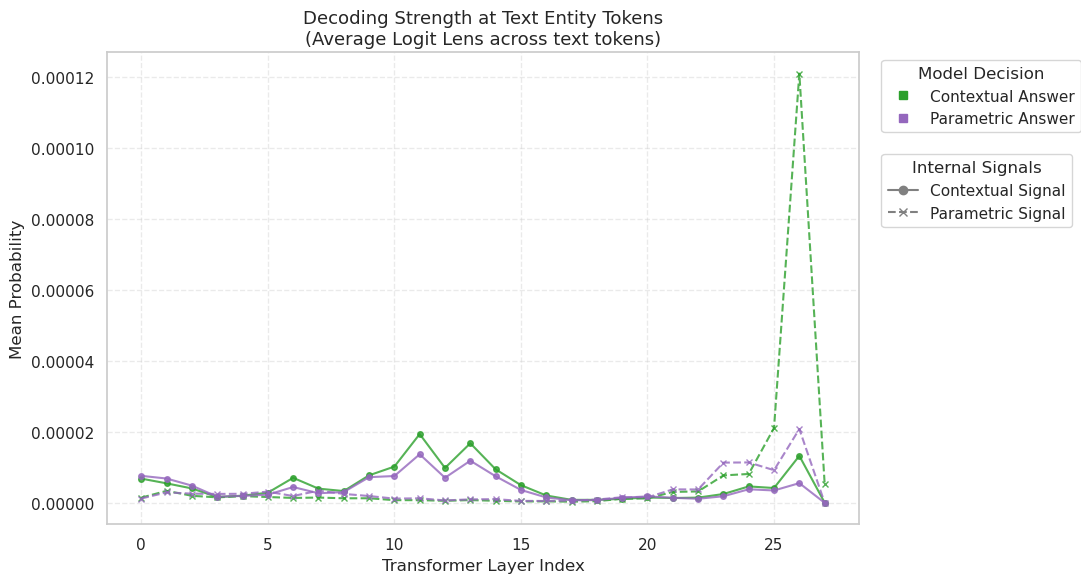

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# 1. Load and Prepare Data
# Path to your new text-only results CSV
OUT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/text-Entity_Logit_Lens_Grouped.csv"
df = pd.read_csv(OUT_CSV)

# Filter for the specific category you are analyzing
df = df[df['Category'] == "Career_error"]

# Group by Layer and Group, calculating mean probability
# Note: Columns are now 'Avg_Text_P_Context' and 'Avg_Text_P_Parametric'
df_avg = df.groupby(['Group', 'Layer'])[['Avg_Text_P_Context', 'Avg_Text_P_Parametric']].mean().reset_index()

# Updated group map for the text-only labels
group_map = {
    'parametric': 'Parametric Answer',
    'context': 'Contextual Answer'
}

metric_map = {
    'Avg_Text_P_Context': 'Contextual Signal',
    'Avg_Text_P_Parametric': 'Parametric Signal'
}

# 2. Plotting
plt.figure(figsize=(11, 6))
groups = df_avg['Group'].unique()
# Use distinct colors for Memory vs. Context dominance
colors = ['#2ca02c', '#9467bd'] # Green and Purple for contrast

for i, group in enumerate(groups):
    subset = df_avg[df_avg['Group'] == group].sort_values('Layer')
    color = colors[i % len(colors)]
    
    # Plot Contextual probability (Solid line)
    plt.plot(subset['Layer'], subset['Avg_Text_P_Context'], 
             color=color, linestyle='-', marker='o', alpha=0.8, markersize=4)
    
    # Plot Parametric probability (Dashed line)
    plt.plot(subset['Layer'], subset['Avg_Text_P_Parametric'], 
             color=color, linestyle='--', marker='x', alpha=0.8, markersize=5)

# --- 3. Custom Legend Construction ---

group_handles = [
    mlines.Line2D([], [], color=colors[i], marker='s', linestyle='None', 
                  label=group_map.get(g, g)) 
    for i, g in enumerate(groups)
]

metric_handles = [
    mlines.Line2D([], [], color='gray', linestyle='-', marker='o', label=metric_map['Avg_Text_P_Context']),
    mlines.Line2D([], [], color='gray', linestyle='--', marker='x', label=metric_map['Avg_Text_P_Parametric'])
]

first_legend = plt.legend(handles=group_handles, title="Model Decision", 
                          loc='upper left', bbox_to_anchor=(1.02, 1))
plt.gca().add_artist(first_legend) 

plt.legend(handles=metric_handles, title="Internal Signals", 
           loc='upper left', bbox_to_anchor=(1.02, 0.8))

plt.title("Decoding Strength at Text Entity Tokens\n(Average Logit Lens across text tokens)", fontsize=13)
plt.xlabel('Transformer Layer Index')
plt.ylabel('Mean Probability')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()

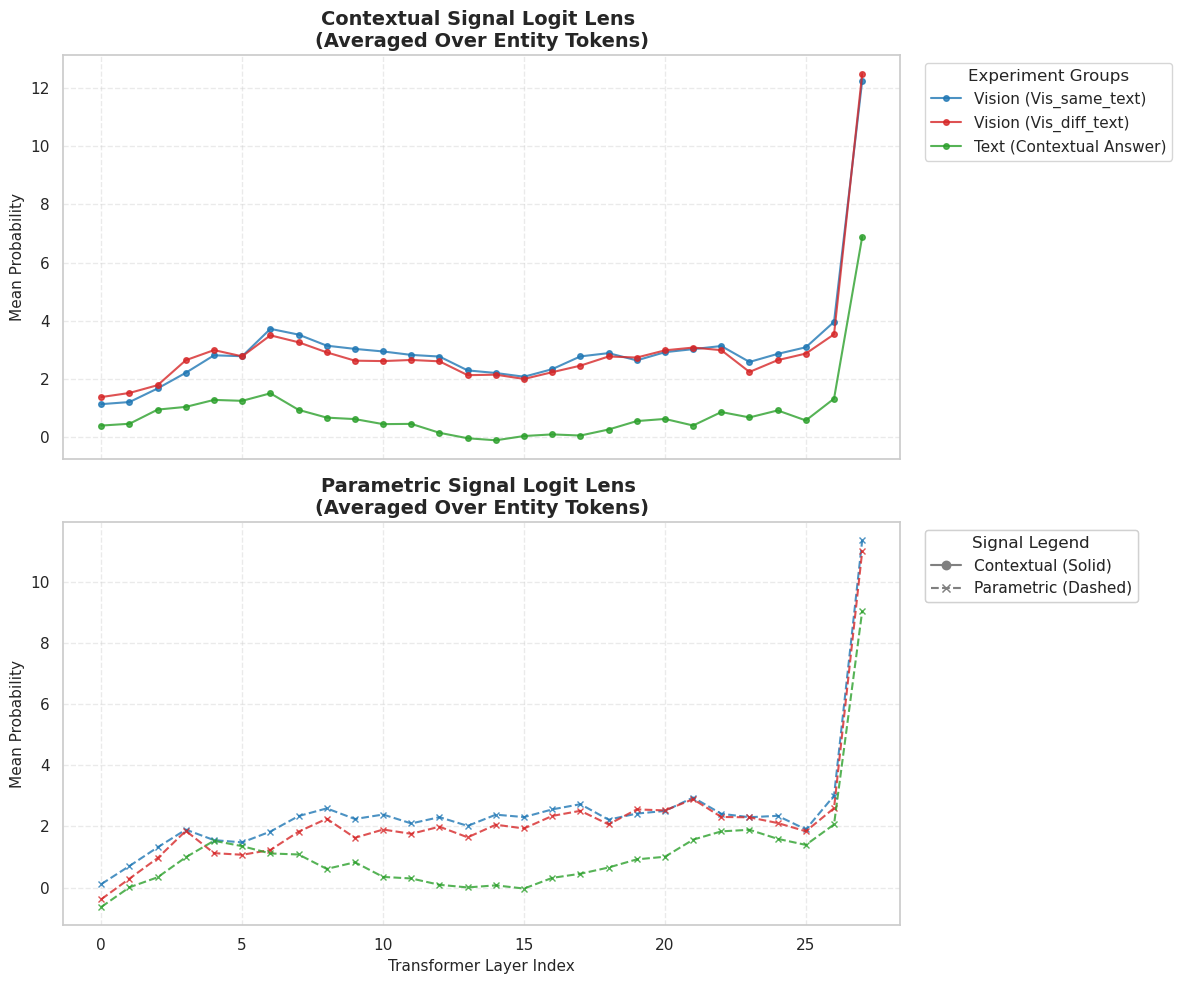

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# --- 1. Load and Prepare Vision Data ---
VISION_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Logit_Lens_Grouped.csv"
df_vis = pd.read_csv(VISION_CSV)
df_vis = df_vis[df_vis['Category'] == "Career_error"]

# Group and average for Vision
df_vis_avg = df_vis.groupby(['Group', 'Layer'])[['Avg_Vision_P_Context', 'Avg_Vision_P_Parametric']].mean().reset_index()

# --- 2. Load and Prepare Text Data ---
TEXT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/text-Entity_Logit_Lens_Grouped.csv"
df_text = pd.read_csv(TEXT_CSV)
df_text = df_text[df_text['Category'] == "Career_error"]

# Filter specifically for the "context" group as requested
df_text = df_text[df_text['Group'] == 'context']

# Group and average for Text
df_text_avg = df_text.groupby(['Group', 'Layer'])[['Avg_Text_P_Context', 'Avg_Text_P_Parametric']].mean().reset_index()

# --- 3. Configuration ---
plot_configs = [
    {
        'df': df_vis_avg[df_vis_avg['Group'] == 'VisCorrect_TextWrong'],
        'label': 'Vision (Vis_same_text)',
        'color': '#1f77b4', # Blue
        'ctx_col': 'Avg_Vision_P_Context',
        'prm_col': 'Avg_Vision_P_Parametric'
    },
    {
        'df': df_vis_avg[df_vis_avg['Group'] == 'Others'],
        'label': 'Vision (Vis_diff_text)',
        'color': '#d62728', # Red
        'ctx_col': 'Avg_Vision_P_Context',
        'prm_col': 'Avg_Vision_P_Parametric'
    },
    {
        'df': df_text_avg, 
        'label': 'Text (Contextual Answer)',
        'color': '#2ca02c', # Green
        'ctx_col': 'Avg_Text_P_Context',
        'prm_col': 'Avg_Text_P_Parametric'
    }
]

# --- 4. Plotting (Two Subplots) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for config in plot_configs:
    subset = config['df'].sort_values('Layer')
    
    # Subplot 1: Contextual Signal (Solid line)
    ax1.plot(subset['Layer'], subset[config['ctx_col']], 
             color=config['color'], linestyle='-', marker='o', 
             alpha=0.8, markersize=4, label=config['label'])
    
    # Subplot 2: Parametric Signal (Dashed line)
    ax2.plot(subset['Layer'], subset[config['prm_col']], 
             color=config['color'], linestyle='--', marker='x', 
             alpha=0.8, markersize=5, label=config['label'])

# --- 5. Formatting and Styling ---

# Upper Plot (Contextual)
ax1.set_title("Contextual Signal Logit Lens \n(Averaged Over Entity Tokens)", fontsize=14, fontweight='bold')
ax1.set_ylabel('Mean Probability', fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(title="Experiment Groups", loc='upper left', bbox_to_anchor=(1.02, 1))

# Lower Plot (Parametric)
ax2.set_title("Parametric Signal Logit Lens \n(Averaged Over Entity Tokens)", fontsize=14, fontweight='bold')
ax2.set_ylabel('Mean Probability', fontsize=11)
ax2.set_xlabel('Transformer Layer Index', fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.4)
# Optional: Reuse same legend or add style legend
metric_legend = [
    mlines.Line2D([], [], color='gray', linestyle='-', marker='o', label='Contextual (Solid)'),
    mlines.Line2D([], [], color='gray', linestyle='--', marker='x', label='Parametric (Dashed)')
]
ax2.add_artist(ax2.legend(title="Signal Legend", handles=metric_legend, loc='upper left', bbox_to_anchor=(1.02, 1)))

plt.tight_layout()
plt.show()

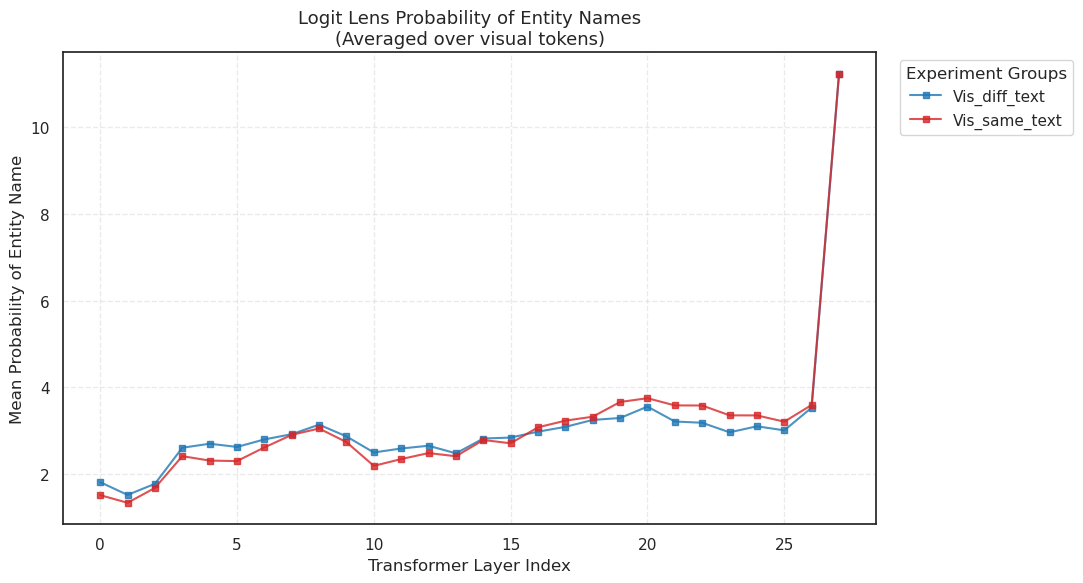

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# 1. Load and Prepare Data
OUT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Logit_Lens_Grouped.csv"
df = pd.read_csv(OUT_CSV)
df = df[df['Category'] == "Career_error"]

# Group by Layer and Group, calculating mean for the specific Entity metric
# Ensure 'Avg_Vision_P_Entity' is in your CSV columns
df_avg = df.groupby(['Group', 'Layer'])['Avg_Vision_P_Entity'].mean().reset_index()

group_map = {
    'VisCorrect_TextWrong': 'Vis_same_text',
    'Others': 'Vis_diff_text'
}

# 2. Plotting
plt.figure(figsize=(11, 6))
groups = df_avg['Group'].unique()
colors = ['#1f77b4', '#d62728'] # Blue and Red

for i, group in enumerate(groups):
    subset = df_avg[df_avg['Group'] == group].sort_values('Layer')
    color = colors[i % len(colors)]
    
    # Plot Entity probability
    plt.plot(subset['Layer'], subset['Avg_Vision_P_Entity'], 
             color=color, linestyle='-', marker='s', alpha=0.8, 
             markersize=5, label=group_map.get(group, group))

# --- 3. Legend and Labels ---

plt.legend(title="Experiment Groups", loc='upper left', bbox_to_anchor=(1.02, 1))

plt.title("Logit Lens Probability of Entity Names\n(Max over visual tokens)", fontsize=13)
plt.xlabel('Transformer Layer Index')
plt.ylabel('Mean Probability of Entity Name')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()

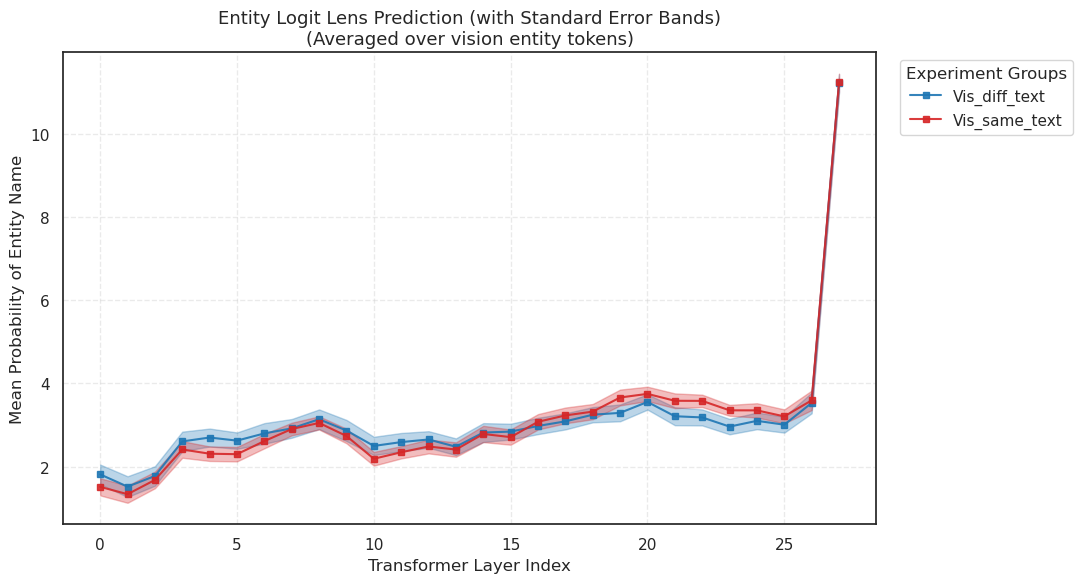

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import sem

# 1. Load and Prepare Data
OUT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Logit_Lens_Grouped.csv"
df = pd.read_csv(OUT_CSV)
df = df[df['Category'] == "Career_error"]

# --- MODIFICATION: Aggregate using Mean and SEM ---
# 'sem' calculates the Standard Error of the Mean
df_stats = df.groupby(['Group', 'Layer'])['Avg_Vision_P_Entity'].agg(['mean', sem]).reset_index()

group_map = {
    'VisCorrect_TextWrong': 'Vis_same_text',
    'Others': 'Vis_diff_text'
}

# 2. Plotting
plt.figure(figsize=(11, 6))
groups = df_stats['Group'].unique()
colors = ['#1f77b4', '#d62728'] 

for i, group in enumerate(groups):
    subset = df_stats[df_stats['Group'] == group].sort_values('Layer')
    color = colors[i % len(colors)]
    
    # Plot the Mean Line
    plt.plot(subset['Layer'], subset['mean'], 
             color=color, linestyle='-', marker='s', alpha=0.9, 
             markersize=5, label=group_map.get(group, group))
    
    # --- MODIFICATION: Fill between Mean +/- SEM ---
    plt.fill_between(
        subset['Layer'], 
        subset['mean'] - subset['sem'], 
        subset['mean'] + subset['sem'], 
        color=color, 
        alpha=0.3  # Slightly higher alpha for SEM since the bands are narrower
    )

# --- 3. Legend and Labels ---
plt.legend(title="Experiment Groups", loc='upper left', bbox_to_anchor=(1.02, 1))

plt.title("Entity Logit Lens Prediction (with Standard Error Bands)\n(Averaged over vision entity tokens)", fontsize=13)
plt.xlabel('Transformer Layer Index')
plt.ylabel('Mean Probability of Entity Name')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()

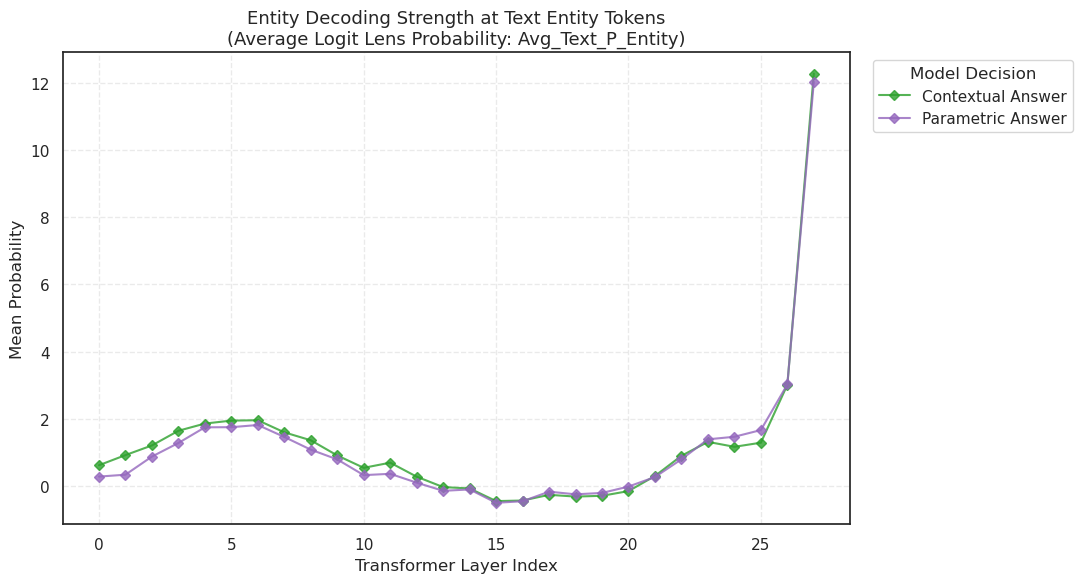

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# 1. Load and Prepare Text Data
# Note: Pointing to the text-specific CSV
OUT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/text-Entity_Logit_Lens_Grouped.csv"
df = pd.read_csv(OUT_CSV)

# Filter for the specific category
df = df[df['Category'] == "Career_error"]

# Group by Layer and Group, calculating mean for the Text Entity metric
df_avg = df.groupby(['Group', 'Layer'])['Avg_Text_P_Entity'].mean().reset_index()

# Updated group map for text labels
group_map = {
    'parametric': 'Parametric Answer',
    'context': 'Contextual Answer'
}

# 2. Plotting
plt.figure(figsize=(11, 6))
groups = df_avg['Group'].unique()
# Using Green and Purple to distinguish from the Vision-based plots
colors = ['#2ca02c', '#9467bd'] 

for i, group in enumerate(groups):
    subset = df_avg[df_avg['Group'] == group].sort_values('Layer')
    color = colors[i % len(colors)]
    
    # Plot Text Entity probability
    plt.plot(subset['Layer'], subset['Avg_Text_P_Entity'], 
             color=color, linestyle='-', marker='D', alpha=0.8, 
             markersize=5, label=group_map.get(group, group))

# --- 3. Legend and Labels ---

plt.legend(title="Model Decision", loc='upper left', bbox_to_anchor=(1.02, 1))

plt.title("Entity Decoding Strength at Text Entity Tokens\n(Average Logit Lens Probability: Avg_Text_P_Entity)", fontsize=13)
plt.xlabel('Transformer Layer Index')
plt.ylabel('Mean Probability')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()

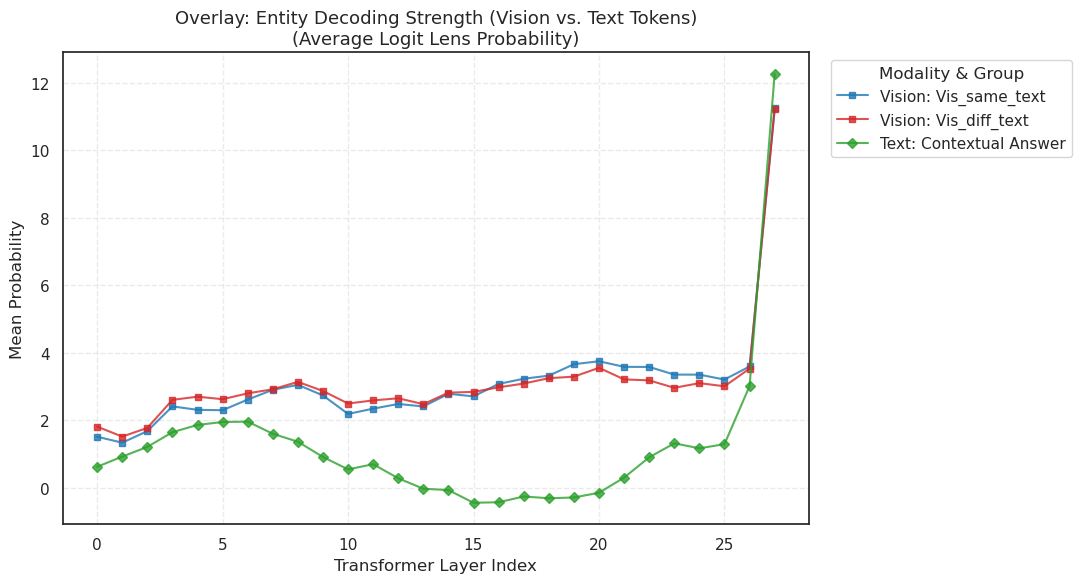

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# --- 1. Load and Prepare Vision Data ---
VIS_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Logit_Lens_Grouped.csv"
df_vis = pd.read_csv(VIS_CSV)
df_vis = df_vis[df_vis['Category'] == "Career_error"]

# Group and average for Vision Entity
df_vis_avg = df_vis.groupby(['Group', 'Layer'])['Avg_Vision_P_Entity'].mean().reset_index()

# --- 2. Load and Prepare Text Data ---
TEXT_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/text-Entity_Logit_Lens_Grouped.csv"
df_text = pd.read_csv(TEXT_CSV)
df_text = df_text[df_text['Category'] == "Career_error"]

# Filter specifically for the "context" group as requested
df_text = df_text[df_text['Group'] == 'context']

# Group and average for Text Entity
df_text_avg = df_text.groupby(['Group', 'Layer'])['Avg_Text_P_Entity'].mean().reset_index()

# --- 3. Plotting Configuration ---
# We'll plot: Blue/Red for Vision tokens and Green for the Text-only contextual token
plot_configs = [
    {
        'df': df_vis_avg[df_vis_avg['Group'] == 'VisCorrect_TextWrong'],
        'label': 'Vision: Vis_same_text',
        'color': '#1f77b4', # Blue
        'col': 'Avg_Vision_P_Entity',
        'marker': 's'
    },
    {
        'df': df_vis_avg[df_vis_avg['Group'] == 'Others'],
        'label': 'Vision: Vis_diff_text',
        'color': '#d62728', # Red
        'col': 'Avg_Vision_P_Entity',
        'marker': 's'
    },
    {
        'df': df_text_avg,
        'label': 'Text: Contextual Answer',
        'color': '#2ca02c', # Green
        'col': 'Avg_Text_P_Entity',
        'marker': 'D'
    }
]

# --- 4. Plotting ---
plt.figure(figsize=(11, 6))

for config in plot_configs:
    subset = config['df'].sort_values('Layer')
    plt.plot(subset['Layer'], subset[config['col']], 
             color=config['color'], linestyle='-', marker=config['marker'], 
             alpha=0.8, markersize=5, label=config['label'])

# --- 5. Labels and Styling ---
plt.title("Overlay: Entity Decoding Strength (Vision vs. Text Tokens)\n(Average Logit Lens Probability)", fontsize=13)
plt.xlabel('Transformer Layer Index')
plt.ylabel('Mean Probability')
plt.legend(title="Modality & Group", loc='upper left', bbox_to_anchor=(1.02, 1))
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()

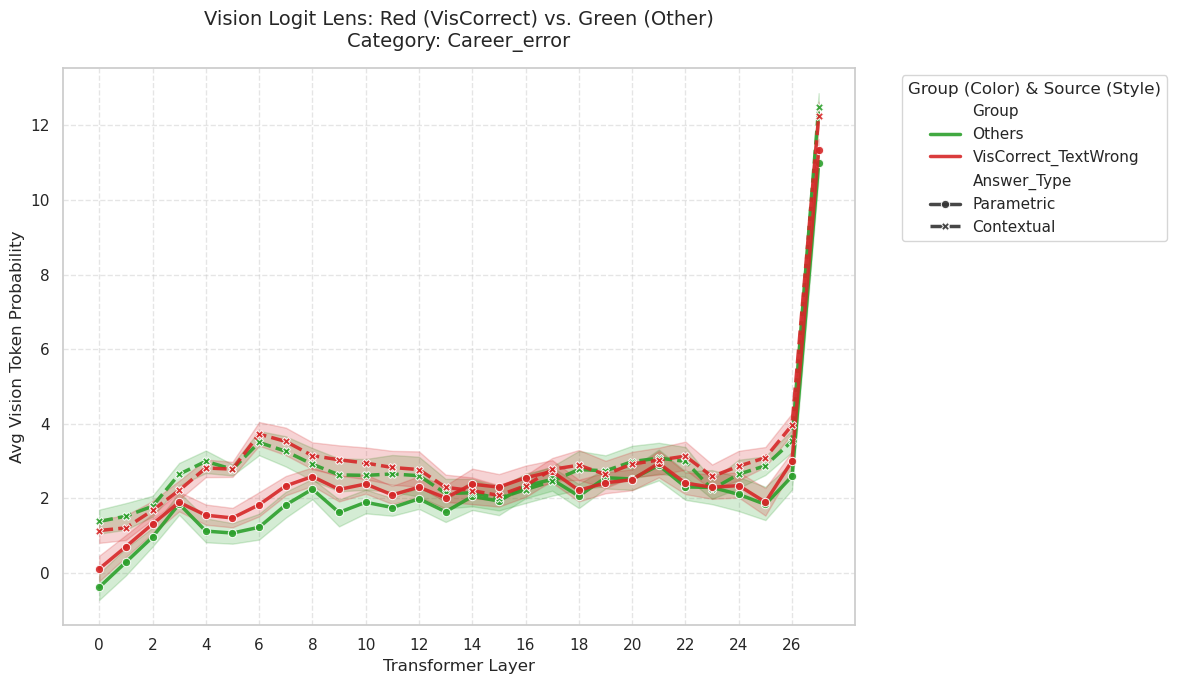

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data
VIS_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Entity_Logit_Lens_Grouped.csv"
df = pd.read_csv(VIS_CSV)

# 2. Filter for Career_error
df_filtered = df[df['Category'] == "Career_error"].copy()

# 3. Reshape for Seaborn
df_melted = df_filtered.melt(
    id_vars=['Layer', 'Group', 'ID'], 
    value_vars=['Avg_Vision_P_Parametric', 'Avg_Vision_P_Context'],
    var_name='Answer_Type', 
    value_name='Value'
)

# Rename for a cleaner legend
df_melted['Answer_Type'] = df_melted['Answer_Type'].replace({
    'Avg_Vision_P_Parametric': 'Parametric',
    'Avg_Vision_P_Context': 'Contextual'
})

# 4. Define Custom Colors
# Mapping: viscorrect -> red, other -> green
custom_palette = {
    "VisCorrect_TextWrong": "#d62728",  # Red
    "Others": "#2ca02c"                # Green
}

# 5. Create the Plot
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

ax = sns.lineplot(
    data=df_melted, 
    x='Layer', 
    y='Value', 
    hue='Group',           
    style='Answer_Type',   
    palette=custom_palette, 
    markers=True, 
    linewidth=2.5,
    alpha=0.9
)

# 6. Formatting
plt.title('Vision Logit Lens: Red (VisCorrect) vs. Green (Other)\nCategory: Career_error', fontsize=14, pad=15)
plt.xlabel('Transformer Layer', fontsize=12)
plt.ylabel('Avg Vision Token Probability', fontsize=12)
plt.xticks(range(0, int(df['Layer'].max()) + 1, 2))
plt.grid(True, linestyle='--', alpha=0.5)

# Improve Legend
plt.legend(title='Group (Color) & Source (Style)', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
#plt.savefig('logit_lens_red_green.png', dpi=300)
plt.show()

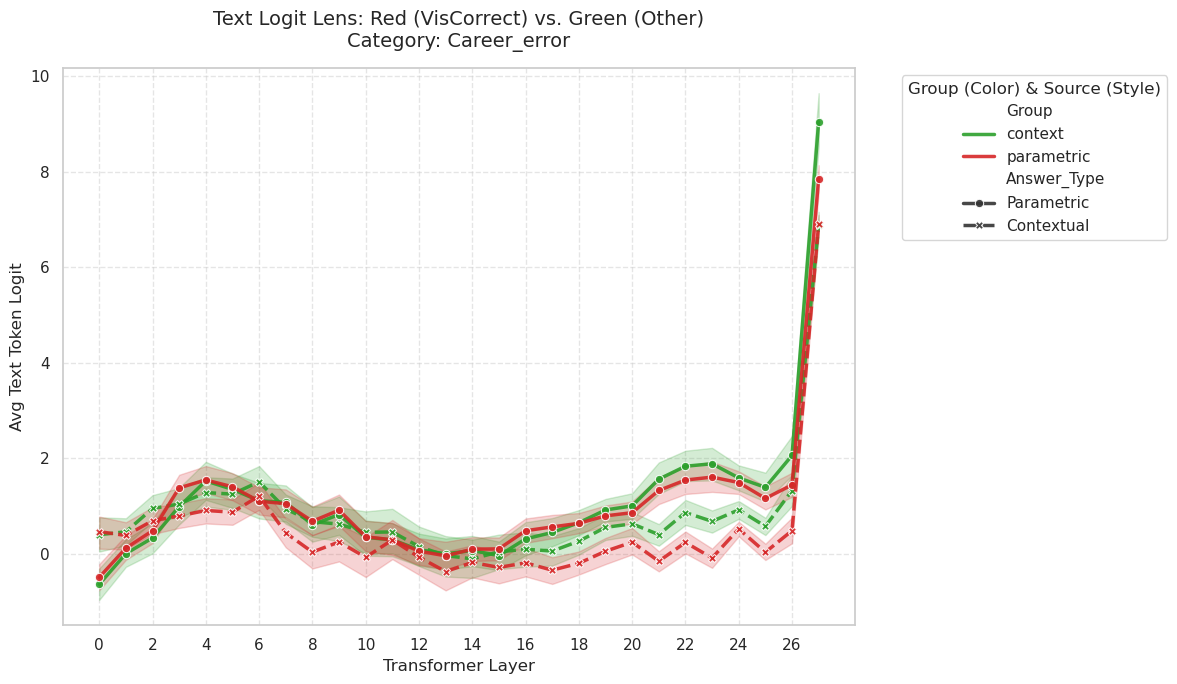

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data
VIS_CSV = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/text-Entity_Logit_Lens_Grouped.csv"
df = pd.read_csv(VIS_CSV)

# 2. Filter for Career_error
df_filtered = df[df['Category'] == "Career_error"].copy()

# 3. Reshape for Seaborn
df_melted = df_filtered.melt(
    id_vars=['Layer', 'Group', 'ID'], 
    value_vars=['Avg_Text_P_Parametric', 'Avg_Text_P_Context'],
    var_name='Answer_Type', 
    value_name='Value'
)

# Rename for a cleaner legend
df_melted['Answer_Type'] = df_melted['Answer_Type'].replace({
    'Avg_Text_P_Parametric': 'Parametric',
    'Avg_Text_P_Context': 'Contextual'
})

# 4. Define Custom Colors
# Mapping: viscorrect -> red, other -> green
custom_palette = {
    "parametric": "#d62728",  # Red
    "context": "#2ca02c"                # Green
}

# 5. Create the Plot
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

ax = sns.lineplot(
    data=df_melted, 
    x='Layer', 
    y='Value', 
    hue='Group',           
    style='Answer_Type',   
    palette=custom_palette, 
    markers=True, 
    linewidth=2.5,
    alpha=0.9
)

# 6. Formatting
plt.title('Text Logit Lens: Red (VisCorrect) vs. Green (Other)\nCategory: Career_error', fontsize=14, pad=15)
plt.xlabel('Transformer Layer', fontsize=12)
plt.ylabel('Avg Text Token Logit', fontsize=12)
plt.xticks(range(0, int(df['Layer'].max()) + 1, 2))
plt.grid(True, linestyle='--', alpha=0.5)

# Improve Legend
plt.legend(title='Group (Color) & Source (Style)', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
#plt.savefig('logit_lens_red_green.png', dpi=300)
plt.show()

In [16]:
df

,ID,Instance,Layer,Avg_Text_P_Parametric,Avg_Text_P_Context,Avg_Text_P_Entity,Group,Category
0,1,Taylor Swift,0,5.062500,5.062500,0.577148,context,Temporal_error
1,1,Taylor Swift,1,4.976562,4.976562,-0.041656,context,Temporal_error
2,1,Taylor Swift,2,5.437500,5.437500,-0.230957,context,Temporal_error
3,1,Taylor Swift,3,3.871094,3.871094,0.513184,context,Temporal_error
4,1,Taylor Swift,4,3.257812,3.257812,1.748047,context,Temporal_error
...,...,...,...,...,...,...,...,...
15451,149,Lupita Nyong'o,23,5.726562,1.244141,7.710938,context,Career_error
15452,149,Lupita Nyong'o,24,3.972656,1.833984,6.003906,context,Career_error
15453,149,Lupita Nyong'o,25,3.423828,1.370117,4.886719,context,Career_error
15454,149,Lupita Nyong'o,26,3.386719,1.925781,3.441406,context,Career_error


# Relationship 

In [22]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/WHO_VISION_Experiment_Results.csv")
df['Knows_celeb'] = df.apply(lambda row: row['Instance'] in row['Response'], axis=1)

unknown_celebs = df[df["Knows_celeb"] == False]['Instance'].unique() 
unknown_celebs = unknown_celebs[1:] # "Remove The Rock from unknown list bc it knows Dwayne Johnson"
unknown_celebs
df_inherent_vision = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_VISION_Experiment_Results.csv")
df_inherent_vision
df_inherent_text = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_Experiment_Results.csv")
df_inherent_vision = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_VISION_Experiment_Results.csv")
df_inherent_text

def get_correct_indices(df):
    # 1. Define the probability columns
    prob_cols = ['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']
    
    # 2. Find the column name with the max value for each row (e.g., "Prob_A")
    # idxmax(axis=1) returns the column label of the maximum value
    predicted_col = df[prob_cols].idxmax(axis=1)
    
    # 3. Clean the prediction to match Ground_Truth format (e.g., "Prob_A" -> "A")
    predicted_choice = predicted_col.str.replace('Prob_', '')
    
    # 4. Compare with Ground Truth
    # We strip whitespace from both just to be safe (e.g. " A" vs "A")
    is_correct = predicted_choice.str.strip() == df['Ground_Truth'].str.strip()
    
    return is_correct

# Get the boolean mask (True/False) for both dataframes
text_correct_mask = get_correct_indices(df_inherent_text)
vision_correct_mask = get_correct_indices(df_inherent_vision)

# Find where BOTH are True
# We use the bitwise AND operator '&'
both_correct_mask = text_correct_mask & vision_correct_mask

# Extract the actual indices
correct_indices = df_inherent_text.index[both_correct_mask].tolist()

print(f"Number of matches: {len(correct_indices)}")
print("Indices:", correct_indices)

df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_Experiment_Results.csv")
df = df.drop_duplicates(subset=['Instance', 'Category','Mis_Knowledge_Key'])
df_inherent_text_corr = df_inherent_text.iloc[correct_indices]
df_inherent_text_corr
corr_inst_cat = df_inherent_text_corr[['Instance', 'Category']].drop_duplicates()
df = df.merge(corr_inst_cat, on=['Instance', 'Category'], how='inner')
df_lang_no_ctxt = df[~df['Instance'].isin(unknown_celebs)]
df_lang_no_ctxt
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_VISION_Experiment_Results.csv")
df = df.drop_duplicates(subset=['Instance', 'Category','Mis_Knowledge_Key'])
df_inherent_text_corr = df_inherent_text.iloc[correct_indices]
df_inherent_text_corr
corr_inst_cat = df_inherent_text_corr[['Instance', 'Category']].drop_duplicates()
df = df.merge(corr_inst_cat, on=['Instance', 'Category'], how='inner')
df_vis_no_ctxt = df[~df['Instance'].isin(unknown_celebs)]
df_vis_no_ctxt

Number of matches: 297
Indices: [0, 1, 2, 4, 5, 8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32, 35, 37, 38, 39, 40, 41, 43, 44, 46, 47, 48, 49, 50, 52, 53, 56, 58, 59, 61, 62, 64, 65, 67, 68, 69, 70, 71, 73, 74, 77, 80, 82, 83, 85, 86, 88, 89, 90, 91, 92, 94, 95, 98, 100, 101, 102, 103, 104, 105, 107, 110, 113, 115, 116, 119, 121, 122, 124, 125, 127, 128, 130, 131, 133, 134, 135, 136, 137, 139, 140, 142, 143, 145, 146, 148, 149, 150, 152, 154, 155, 157, 158, 160, 161, 163, 164, 167, 168, 170, 171, 172, 173, 175, 176, 178, 179, 181, 182, 185, 187, 188, 190, 191, 193, 194, 196, 197, 199, 200, 202, 203, 205, 206, 208, 209, 211, 212, 213, 214, 215, 217, 218, 220, 221, 223, 224, 226, 227, 229, 230, 231, 232, 233, 235, 236, 238, 239, 240, 241, 242, 245, 247, 248, 251, 253, 254, 256, 257, 259, 260, 261, 262, 263, 265, 266, 268, 269, 271, 272, 274, 275, 276, 277, 278, 280, 281, 284, 286, 287, 289, 290, 292, 293, 294, 296, 299, 301, 302, 304, 305, 306, 307, 308, 310, 311, 313

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
0,1,Taylor Swift,Temporal_error,mis_knowledge1,NaN,What year was the entity born? Answers: A) 198...,system\nYou are a helpful assistant.\nuser\nGi...,0.055725,0.098572,0.838379,0.007481,C,A
1,1,Taylor Swift,location_error,mis_knowledge1,NaN,What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nGi...,0.011787,0.006115,0.000635,0.981445,D,B
2,1,Taylor Swift,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.999512,0.000392,0.000019,0.000054,A,B
3,2,Elon Musk,Temporal_error,mis_knowledge1,NaN,What year was the entity born? Answers: A) 197...,system\nYou are a helpful assistant.\nuser\nGi...,0.010124,0.636230,0.237793,0.115845,C,A
4,2,Elon Musk,location_error,mis_knowledge1,NaN,What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nGi...,0.958984,0.001837,0.037781,0.001303,A,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,147,Shia LaBeouf,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.999023,0.000810,0.000072,0.000203,A,B
286,148,Chadwick Boseman,location_error,mis_knowledge1,NaN,What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nGi...,0.015144,0.001547,0.001572,0.981934,D,C
287,148,Chadwick Boseman,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.001387,0.000635,0.997559,0.000655,C,B
288,149,Lupita Nyong'o,location_error,mis_knowledge1,NaN,What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nGi...,0.277832,0.519043,0.185059,0.017899,B,A


In [23]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/RAG_Experiment_Results.csv")
df = df.drop_duplicates(subset=['Instance', 'Category','Mis_Knowledge_Key'])
df_inherent_text_corr = df_inherent_text.iloc[correct_indices]
df_inherent_text_corr
corr_inst_cat = df_inherent_text_corr[['Instance', 'Category']].drop_duplicates()
df = df.merge(corr_inst_cat, on=['Instance', 'Category'], how='inner')
df_lang = df[~df['Instance'].isin(unknown_celebs)]
df_lang
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/RAG_VISION_Experiment_Results.csv")
df = df.drop_duplicates(subset=['Instance', 'Category','Mis_Knowledge_Key'])
df_inherent_text_corr = df_inherent_text.iloc[correct_indices]
df_inherent_text_corr
corr_inst_cat = df_inherent_text_corr[['Instance', 'Category']].drop_duplicates()
df = df.merge(corr_inst_cat, on=['Instance', 'Category'], how='inner')
df_vis = df[~df['Instance'].isin(unknown_celebs)]
df_vis
prob_cols = ['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']
df_lang['Pred'] = df_lang[prob_cols].idxmax(axis=1).str[-1]
df_vis['Pred'] = df_vis[prob_cols].idxmax(axis=1).str[-1]
df_lang = df_lang[df_lang["Pred"] == df_lang["Mis_Answer_Label"]]# ONLY KEEP ROWS WHERE PREDICTION WAS THE CONTEXT ANSWER
df_lang = df_lang[df_lang["Category"] == "Career_error"] #ONLY CHECKING CAREER ERROR
df_vis = df_vis.merge( #ONLY KEEP CORRESPONDING ROWS IN VISION
    df_lang[['Instance', 'Category', 'Mis_Knowledge_Key']], 
    on=['Instance', 'Category', 'Mis_Knowledge_Key'], 
    how='inner'
)
df_inherent_vision = df_inherent_vision.merge( #ONLY KEEP CORRESPONDING ROWS IN VISION
    df_vis[['Instance', 'Category']], 
    on=['Instance', 'Category'], 
    how='inner'
)

# Same prediction masks 
same_pred_mask = (df_vis['Pred'] == df_vis['Pred']) 

# mask for when vision is parametric answer 
vis_corr_text_wrong_mask = (df_vis['Pred'] == df_vis['Ground_Truth'])

# Apply grouping
df_vis['Group'] = 'Exclude'
df_vis.loc[same_pred_mask, 'Group'] = 'Context_Pred'
df_vis.loc[vis_corr_text_wrong_mask, 'Group'] = 'Param_Pred'
print(df_vis['Group'].value_counts())

#NOW Figure out if theres a relation between no context conflict confidence 
vis_param_pred_celebs = df_vis[df_vis['Group'] == "Param_Pred"]["Instance"].unique()
df_inherent_vision = df_inherent_vision.drop_duplicates(['Instance','Category'])
df_inherent_vision["Conflict_Pred"] = df_inherent_vision["Instance"].apply(lambda x: "Param_Pred" if x in vis_param_pred_celebs else "Context_Pred")
df_inherent_vision

Group
Param_Pred      65
Context_Pred    50
Name: count, dtype: int64


/tmp/ipykernel_1140825/1667522032.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vis['Pred'] = df_vis[prob_cols].idxmax(axis=1).str[-1]


,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label,Conflict_Pred
0,1,Taylor Swift,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.999512,0.000392,0.000019,0.000054,A,B,Context_Pred
2,3,Cristiano Ronaldo,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.000798,0.999023,0.000038,0.000143,B,C,Param_Pred
3,4,Dwayne Johnson,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.000532,0.999023,0.000020,0.000276,B,D,Param_Pred
4,5,Kim Kardashian,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.000656,0.999023,0.000035,0.000046,B,C,Param_Pred
5,6,Kanye West,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.001293,0.000606,0.997559,0.000597,C,A,Context_Pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,139,Steve Carell,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.999512,0.000371,0.000024,0.000079,A,C,Param_Pred
108,145,Zac Efron,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.001016,0.000414,0.000054,0.998535,D,B,Context_Pred
109,146,Kristen Stewart,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.000419,0.001231,0.995117,0.003023,C,B,Param_Pred
111,148,Chadwick Boseman,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.001387,0.000635,0.997559,0.000655,C,B,Param_Pred


### This tells us that out of the 115 times where text answers with the contextual answer (42% of the time), the vision alternative answers with the parametric answer instead 65 times

/tmp/ipykernel_1140825/2414675702.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Conflict_Pred', y='GT_Prob', data=df_inherent_vision, palette=['#1f77b4', '#d62728'], showfliers=False)


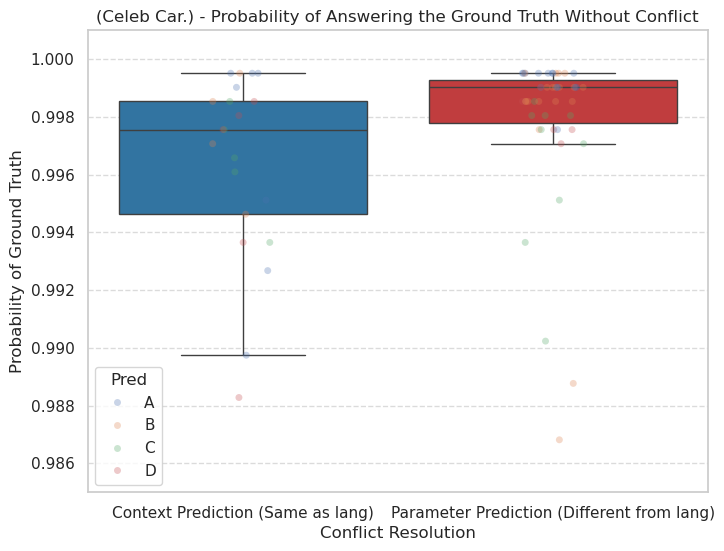

In [24]:
#plot
prob_cols = ['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']
df_inherent_vision['Pred'] = df_inherent_vision[prob_cols].idxmax(axis=1).str[-1]
def get_gt_prob(row):
    gt_col = f'Prob_{row["Ground_Truth"]}'
    return row[gt_col]

df_inherent_vision['GT_Prob'] = df_inherent_vision.apply(get_gt_prob, axis=1)


plt.figure(figsize=(8, 6))




# Create the box plot
sns.boxplot(x='Conflict_Pred', y='GT_Prob', data=df_inherent_vision, palette=['#1f77b4', '#d62728'], showfliers=False)

# Overlay the strip plot to see individual points
sns.stripplot(x='Conflict_Pred', y='GT_Prob', data=df_inherent_vision,hue='Pred', alpha=0.3, jitter=True)

# Change X-axis names
plt.xticks(ticks=[0, 1], labels=['Context Prediction (Same as lang)', 'Parameter Prediction (Different from lang)'])

plt.title('(Celeb Car.) - Probability of Answering the Ground Truth Without Conflict')
plt.ylabel('Probability of Ground Truth')
plt.xlabel('Conflict Resolution')
plt.ylim(0.985, 1.001) 
plt.grid(axis='y', linestyle='--', alpha=0.7)


In [25]:
import pandas as pd
pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/RAG_VISION_Experiment_Results.csv")

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
0,1,Taylor Swift,Temporal_error,mis_knowledge1,"Taylor Swift was born on December 13, 1988. Ta...",What year was the entity born? Answers: A) 198...,system\nYou are a helpful assistant.\nuser\nCo...,0.994629,0.004326,0.000329,0.000690,C,A
1,1,Taylor Swift,Temporal_error,mis_knowledge2,"Taylor Swift was born on December 13, 1990. Ta...",What year was the entity born? Answers: A) 198...,system\nYou are a helpful assistant.\nuser\nCo...,0.001130,0.995605,0.002045,0.001406,C,B
2,1,Taylor Swift,location_error,mis_knowledge1,"Taylor Swift was born on December 13, 1989. Ta...",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.000566,0.998535,0.000284,0.000458,D,B
3,1,Taylor Swift,location_error,mis_knowledge2,"Taylor Swift was born on December 13, 1989. Ta...",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.409424,0.150635,0.003983,0.435791,D,A
4,1,Taylor Swift,Career_error,mis_knowledge1,"Taylor Swift was born on December 13, 1989. Ta...",What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nCo...,0.259766,0.739746,0.000180,0.000109,A,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,149,Lupita Nyong'o,Temporal_error,mis_knowledge2,"Lupita Nyong'o was born on March 1, 1984. Lupi...",What year was the entity born? Answers: A) 198...,system\nYou are a helpful assistant.\nuser\nCo...,0.992676,0.005722,0.000156,0.001287,D,A
890,149,Lupita Nyong'o,location_error,mis_knowledge1,"Lupita Nyong'o was born on March 1, 1983. Lupi...",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.999023,0.000830,0.000052,0.000038,B,A
891,149,Lupita Nyong'o,location_error,mis_knowledge2,"Lupita Nyong'o was born on March 1, 1983. Lupi...",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.001263,0.001168,0.997559,0.000134,B,C
892,149,Lupita Nyong'o,Career_error,mis_knowledge1,"Lupita Nyong'o was born on March 1, 1983. Lupi...",What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nCo...,0.636719,0.362549,0.000339,0.000528,B,A
